In [8]:
import numpy as np
import cv2

In [19]:


def compute_mean_and_cov(image):
    """Compute mean and covariance of the color distribution."""
    reshaped = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped, axis=0)
    cov = np.cov(reshaped, rowvar=False)
    return mean, cov

def sqrtm(matrix, method="svd"):
    """Compute the square root of a positive semi-definite matrix."""
    if method == "svd":
        U, S, Vt = np.linalg.svd(matrix)
        return np.dot(U, np.dot(np.diag(np.sqrt(S)), Vt))
    elif method == "eigen":
        eigvals, eigvecs = np.linalg.eigh(matrix)
        sqrt_diag = np.diag(np.sqrt(eigvals))
        return eigvecs @ sqrt_diag @ eigvecs.T
    elif method == "cholesky":
        L = np.linalg.cholesky(matrix)
        return L
    else:
        raise ValueError("Invalid method for matrix square root")

def separable_transfer(target, reference):
    """Separable linear transfer (Reinhard et al.) - Matches means and variances independently."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    scale = np.sqrt(np.diag(cov_r)) / np.sqrt(np.diag(cov_t))
    transform = np.diag(scale)

    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)
    
    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def cholesky_transfer(target, reference):
    """Cholesky-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    L_t = np.linalg.cholesky(cov_t)
    L_r = np.linalg.cholesky(cov_r)

    transform = L_r @ np.linalg.inv(L_t)
    
    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def pca_transfer(target, reference):
    """Principal Component Analysis (PCA)-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    sqrt_cov_t = sqrtm(cov_t, method="eigen")
    sqrt_cov_r = sqrtm(cov_r, method="eigen")

    transform = sqrt_cov_r @ np.linalg.inv(sqrt_cov_t)

    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def monge_kantorovitch_transfer(target, reference):
    """Monge-Kantorovitch Optimal Transport-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    sqrt_cov_t = sqrtm(cov_t, method="svd")
    inv_sqrt_cov_t = np.linalg.inv(sqrt_cov_t)
    mk_transform = inv_sqrt_cov_t @ sqrtm(sqrt_cov_t @ cov_r @ sqrt_cov_t, method="svd") @ inv_sqrt_cov_t

    transformed = np.dot((target.reshape(-1, 3) - mu_t), mk_transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def convert_color_space(image, from_space, to_space):
    """Convert image between different color spaces."""
    conversion_code = {
        ("RGB", "YUV"): cv2.COLOR_RGB2YUV,
        ("YUV", "RGB"): cv2.COLOR_YUV2RGB,
        ("RGB", "LAB"): cv2.COLOR_RGB2LAB,
        ("LAB", "RGB"): cv2.COLOR_LAB2RGB,
        ("RGB", "XYZ"): cv2.COLOR_RGB2XYZ,
        ("XYZ", "RGB"): cv2.COLOR_XYZ2RGB,
        ("RGB", "LUV"): cv2.COLOR_RGB2LUV,
        ("LUV", "RGB"): cv2.COLOR_LUV2RGB
    }
    return cv2.cvtColor(image, conversion_code[(from_space, to_space)])

import matplotlib.pyplot as plt

def run_all_transfers(target_path, reference_path, color_space="RGB"):
    """Run all color transfer methods and display results using Matplotlib."""
    target = cv2.imread(target_path)
    reference = cv2.imread(reference_path)

    if color_space != "RGB":
        target = convert_color_space(target, "RGB", color_space)
        reference = convert_color_space(reference, "RGB", color_space)

    results = {
        "Target": target,
        "Reference": reference,
        "Separable": separable_transfer(target, reference),
        "Cholesky": cholesky_transfer(target, reference),
        "PCA": pca_transfer(target, reference),
        "Monge-Kantorovitch": monge_kantorovitch_transfer(target, reference)
    }

    if color_space != "RGB":
        for key in results:
            results[key] = convert_color_space(results[key], color_space, "RGB")

    # Convert images from BGR (OpenCV default) to RGB for matplotlib
    for key in results:
        results[key] = cv2.cvtColor(results[key], cv2.COLOR_BGR2RGB)

    # Plot results
    plt.figure(figsize=(12, 8))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.title(name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()




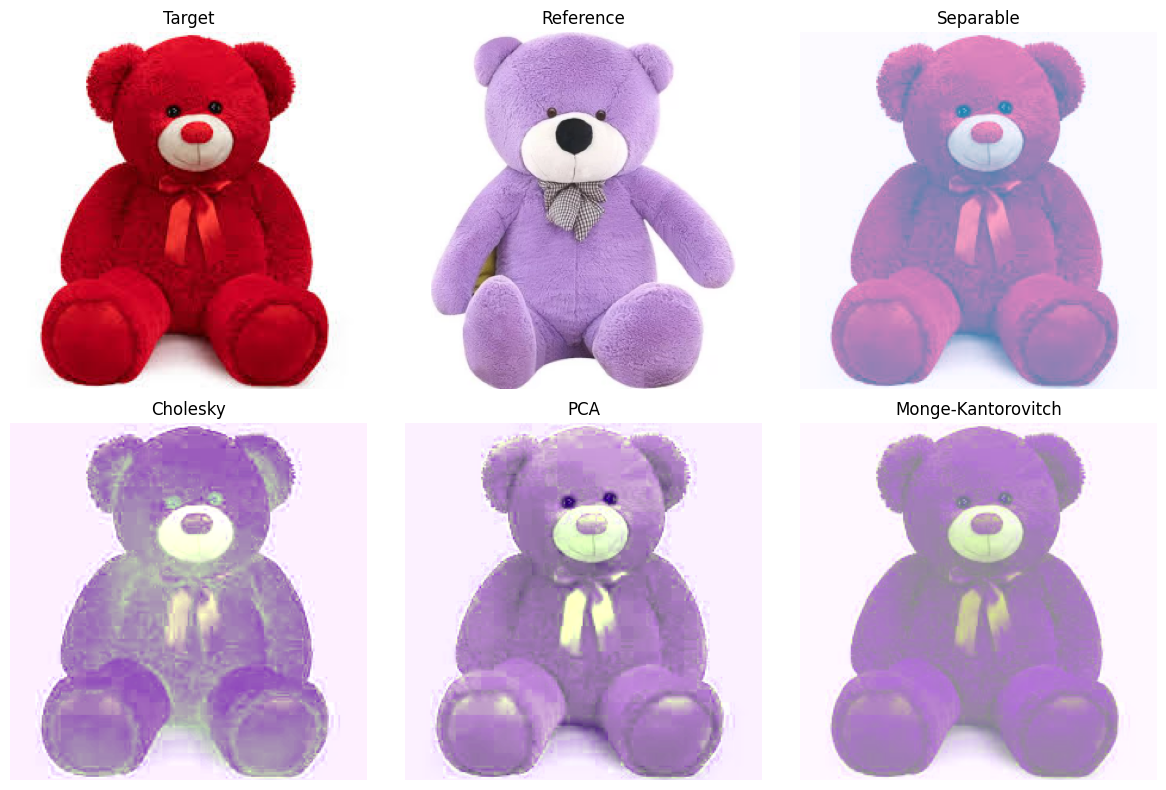

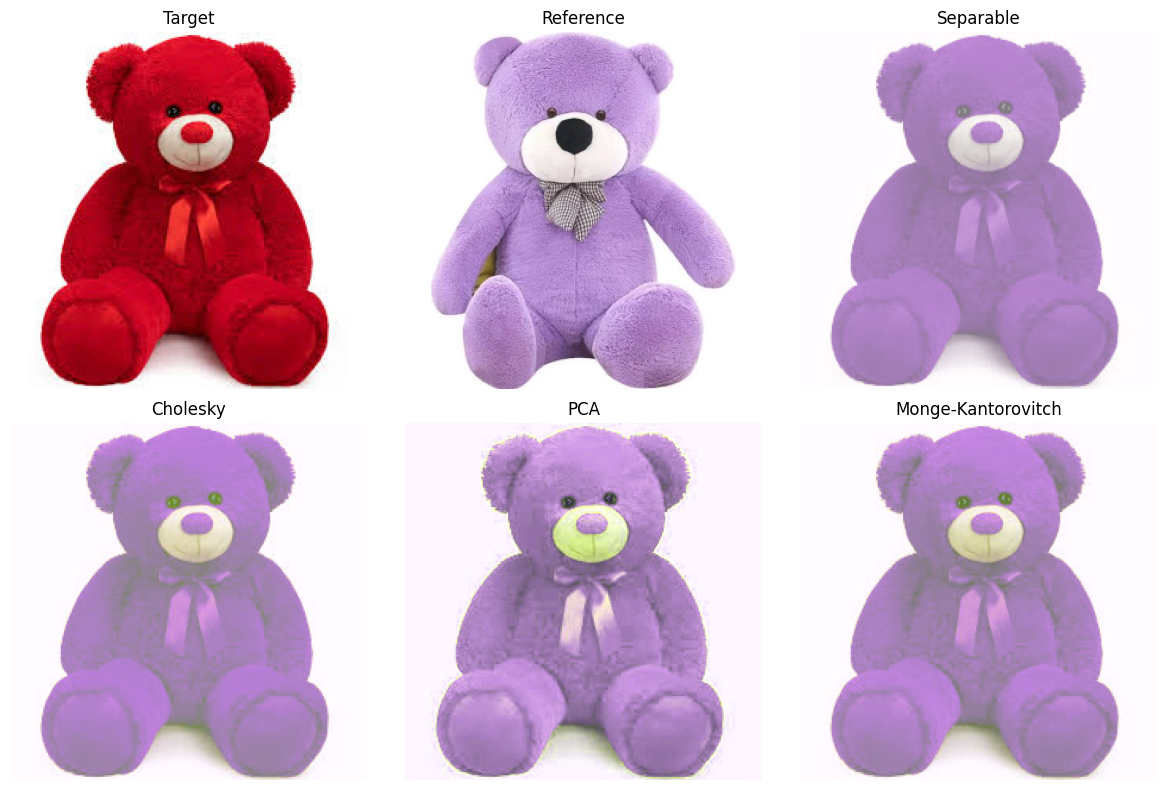

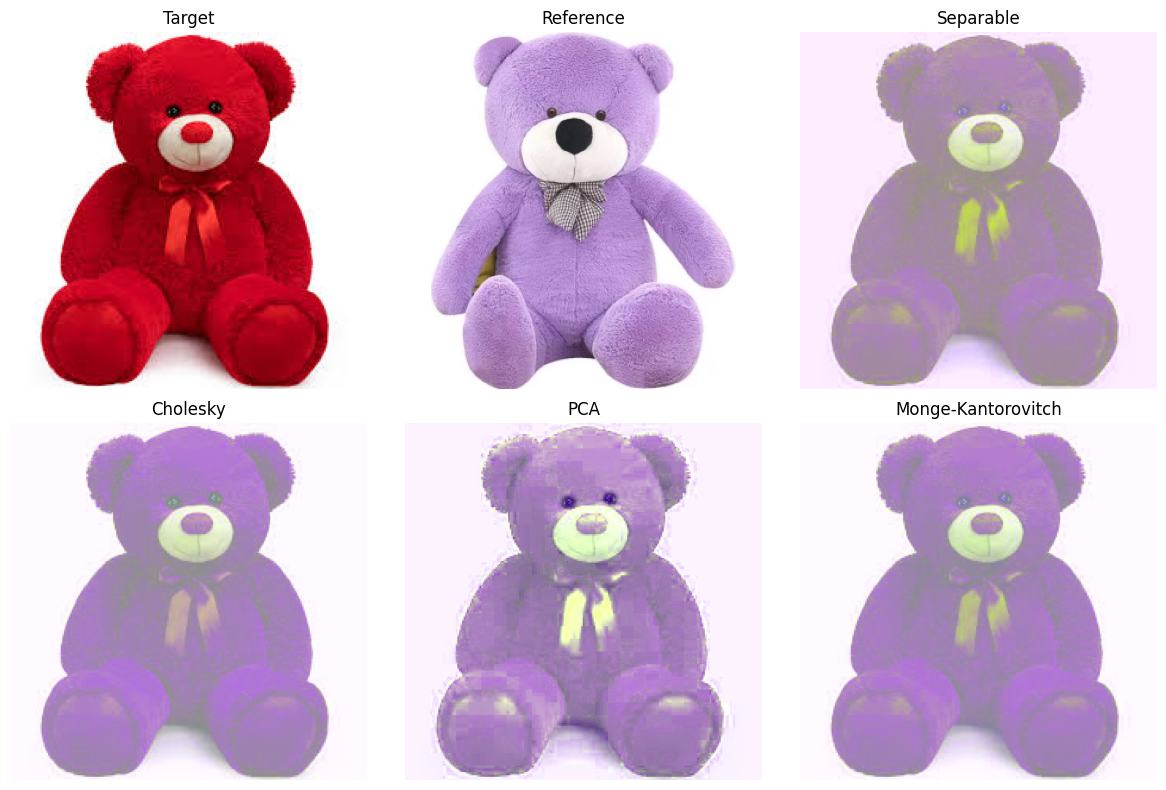

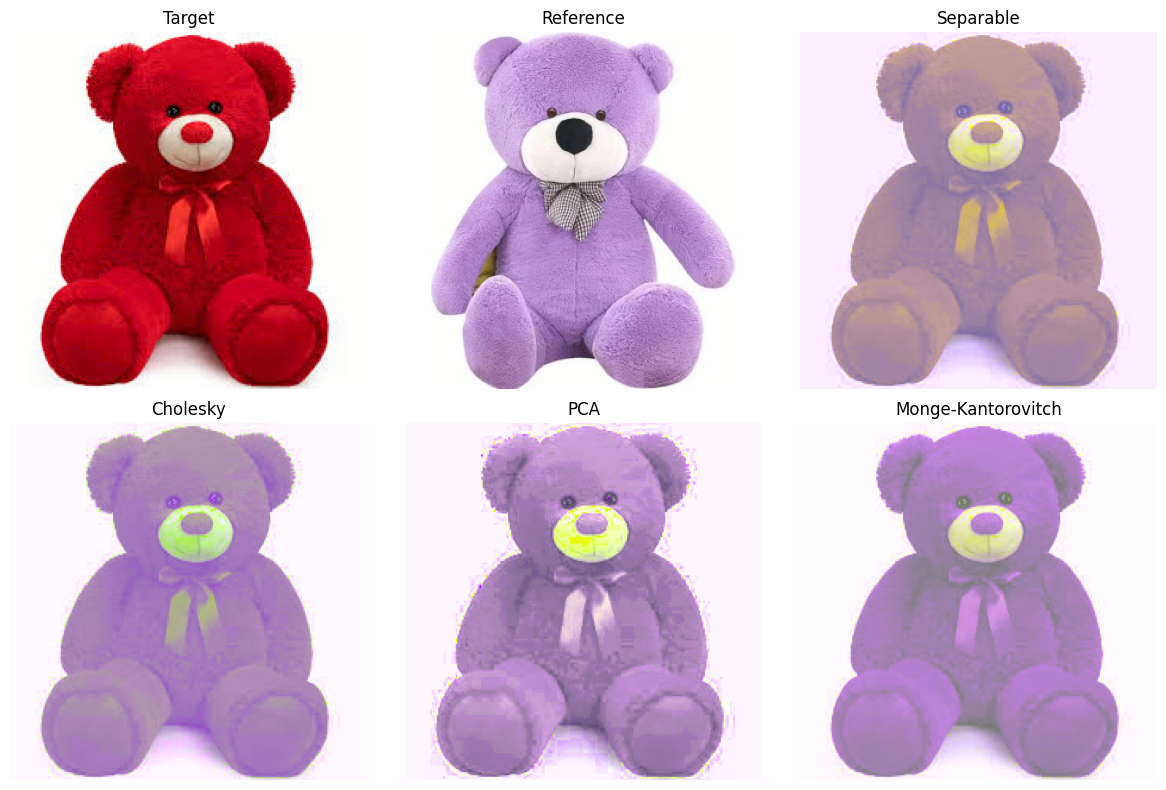

In [20]:
# Example Usage
if __name__ == "__main__":
    target_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/red_teddy.jpeg"
    reference_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/purple_teddy.jpeg"

    # Run all transfers in RGB
    run_all_transfers(target_img_path, reference_img_path, "RGB")

    # Run all transfers in LAB
    run_all_transfers(target_img_path, reference_img_path, "LAB")

    # Run all transfers in YUV
    run_all_transfers(target_img_path, reference_img_path, "YUV")

    # Run all transfers in CIELUV
    run_all_transfers(target_img_path, reference_img_path, "LUV")


In [22]:
import cv2
import numpy as np
from scipy.linalg import sqrtm
from numpy.linalg import cholesky, svd, inv, qr, eig


# use the style of img1 to modify img2
# summarize the basic steps of linear color transfer
def color_trans_linear(img1, img2, func):
    shape2 = img2.shape
    img1 = img1.reshape((-1, img1.shape[-1]))
    img2 = img2.reshape((-1, img1.shape[-1]))
    mean1 = np.mean(img1, axis=0)
    mean2 = np.mean(img2, axis=0)
    cov1 = np.cov(img1.T)
    cov2 = np.cov(img2.T)
    t = func(cov1, cov2)
    ret = (img2 - mean2) @ t.T + mean1
    return ret.reshape(shape2)


# SVD decomposition
# implements the paper Color Transfer in Correlated Color Space by Xuezhong Xiao et al.
# the formula in the original paper mistakenly omitted some square roots and I fixed that here
def trans_svd(cov1, cov2):
    u1, lambda1, _ = svd(cov1)
    u2, lambda2, _ = svd(cov2)
    return u1 @ np.diag(np.sqrt(lambda1)) @ np.diag(1 / (np.sqrt(lambda2) + 1e-12)) @ inv(u2)


# assume that three channels are not correlated
# implements the paper Color Transfer between Images by Erik Reinhard et al.
def trans_indep(cov1, cov2):
    diag1 = np.diagonal(cov1)**0.5
    diag2 = np.diagonal(cov2)**0.5
    return np.diag(diag1 / diag2)


# Cholesky decomposition
# implements the Cholesky method in the paper The Linear Monge-Kantorovitch Linear Colour Mapping for Example-Based Colour Transfer by F. Pitie et al.
def trans_cholesky(cov1, cov2):
    return cholesky(cov1) @ inv(cholesky(cov2))


# Monge-Kantorovitch method
# implements the MK method in the paper The Linear Monge-Kantorovitch Linear Colour Mapping for Example-Based Colour Transfer by F. Pitie et al.
def trans_mk(cov1, cov2):
    t = sqrtm(cov2) @ cov1 @ sqrtm(cov2)
    return inv(sqrtm(cov2)) @ sqrtm(t) @ inv(sqrtm(cov2))


# Square root decomposition
# implements the SQRT method method in the paper The Linear Monge-Kantorovitch Linear Colour Mapping for Example-Based Colour Transfer by F. Pitie et al.
def trans_sqrt(cov1, cov2):
    return sqrtm(cov1) @ inv(sqrtm(cov2))


# implements the color space transform between RGB and l-alpha-beta in the papers
# Color Transfer between Images by Erik Reinhard et al. and
# Statistics of cone responses to natural images:implications for visual coding by Daniel L. Ruderman et al.
RGB2XYZ = np.array([
    [0.5141, 0.3239, 0.1604],
    [0.2651, 0.6702, 0.0641],
    [0.0241, 0.1228, 0.8444]
])
XYZ2LMS = np.array([
    [0.3897, 0.6890, -0.0787],
    [-0.2298, 1.1834, 0.0464],
    [0, 0, 1]
])
RGB2LMS = XYZ2LMS @ RGB2XYZ
LMS2RGB = inv(RGB2LMS)
lgLMS2lab = np.diag([1 / np.sqrt(3), 1 / np.sqrt(6), 1 / np.sqrt(2)]) @ np.array([
    [1, 1, 1],
    [1, 1, -2],
    [1, -1, 0]
])
lab2lgLMS = inv(lgLMS2lab)


def rgb2lab(img):
    return np.log10(img @ RGB2LMS.T + 1e-12) @ lgLMS2lab.T # add a very small number to avoid log(0) error


def lab2rgb(img):
    return (10 ** (img @ lab2lgLMS.T)) @ LMS2RGB.T


def main():
    color_space_from = cv2.COLOR_BGR2RGB
    color_space_to = cv2.COLOR_RGB2BGR

    img1 = cv2.imread('/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/purple_teddy.jpeg')
    img2 = cv2.imread('/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/red_teddy.jpeg')

    img1 = cv2.cvtColor(img1, color_space_from)
    img2 = cv2.cvtColor(img2, color_space_from)

    result = color_trans_linear(rgb2lab(img1), rgb2lab(img2), trans_indep)
    result = lab2rgb(result)
    result = cv2.cvtColor(cv2.convertScaleAbs(result), color_space_to)
    cv2.imwrite('indep.jpg', result)

    result = color_trans_linear(img1, img2, trans_cholesky)
    result = cv2.cvtColor(cv2.convertScaleAbs(result), color_space_to)
    cv2.imwrite('cholesky.jpg', result)

    result = color_trans_linear(img1, img2, trans_sqrt)
    result = cv2.cvtColor(cv2.convertScaleAbs(result), color_space_to)
    cv2.imwrite('sqrt.jpg', result)

    result = color_trans_linear(img1, img2, trans_mk)
    result = cv2.cvtColor(cv2.convertScaleAbs(result), color_space_to)
    cv2.imwrite('mk.jpg', result)

    result = color_trans_linear(img1, img2, trans_svd)
    result = cv2.cvtColor(cv2.convertScaleAbs(result), color_space_to)
    cv2.imwrite('svd.jpg', result)
    return


if __name__ == '__main__':
    main()